
Shape of SHAP values: (5, 1, 28, 28, 10)


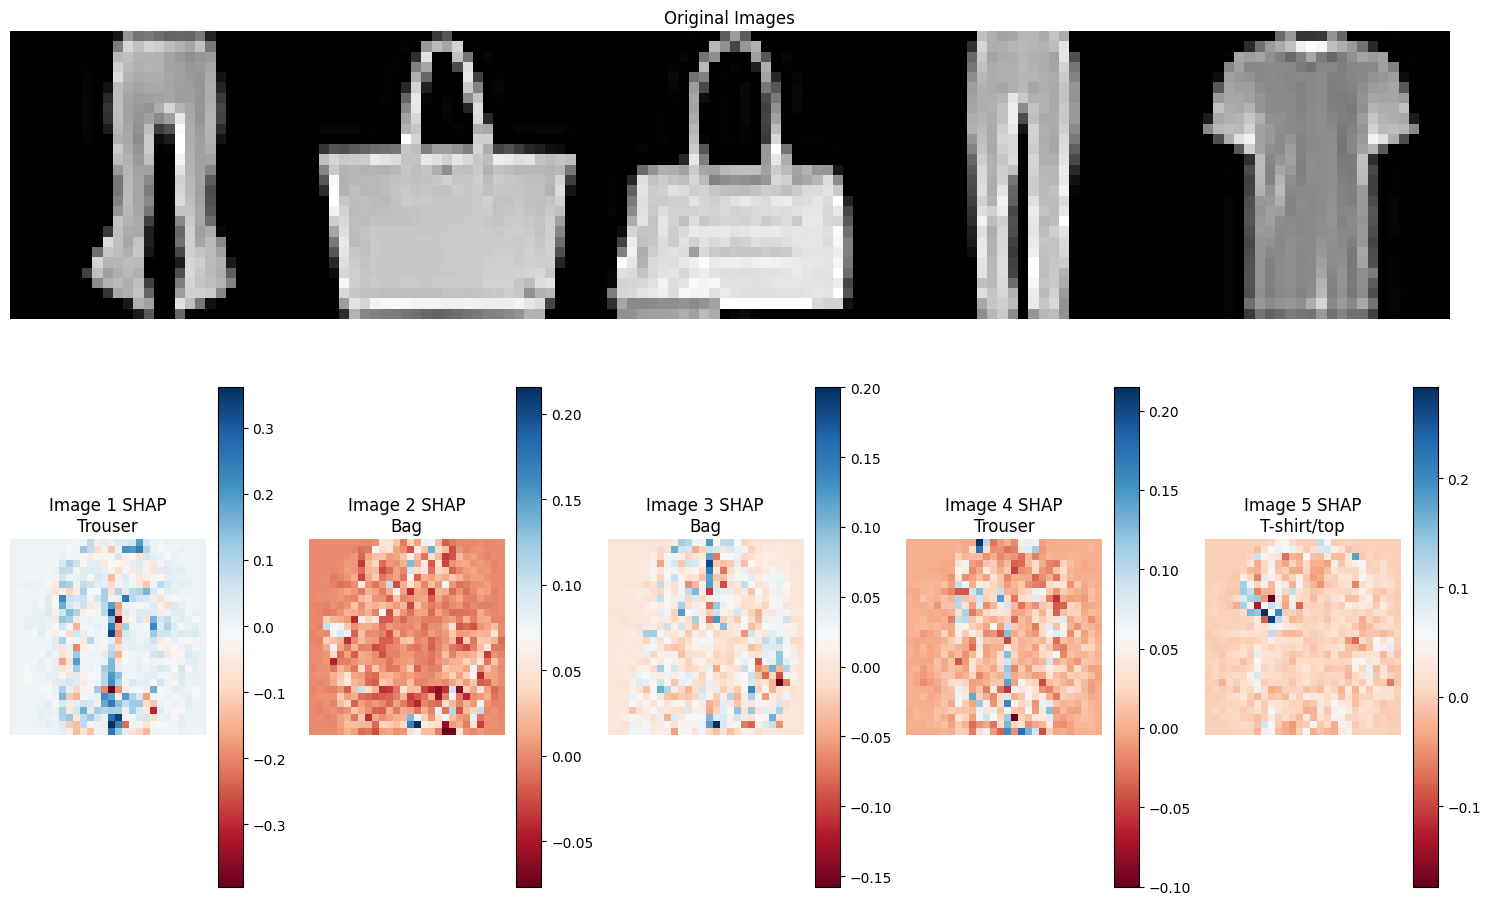


Predictions and Feature Importance:
Image 1: Trouser (Confidence: 99.68%)
Mean absolute SHAP value: 0.0385
Image 2: Bag (Confidence: 99.55%)
Mean absolute SHAP value: 0.0164
Image 3: Bag (Confidence: 99.32%)
Mean absolute SHAP value: 0.0204
Image 4: Trouser (Confidence: 99.86%)
Mean absolute SHAP value: 0.0194
Image 5: T-shirt/top (Confidence: 95.61%)
Mean absolute SHAP value: 0.0185


In [32]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Load your PyTorch model with weights_only=True for security
model = torch.load("./transformer_mnist.pth", map_location=torch.device('cpu'), weights_only=True)
model.eval()

# Load Fashion MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.FashionMNIST(root="./cnn-data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

# Get background data
background, _ = next(iter(test_loader))

# Get test samples
test_loader_samples = DataLoader(test_dataset, batch_size=5, shuffle=True)
test_samples, labels = next(iter(test_loader_samples))

# Create explainer
explainer = shap.GradientExplainer(model, background)

# Get SHAP values and print shape information
shap_values = explainer.shap_values(test_samples)
print(f"\nShape of SHAP values: {shap_values.shape}")

# Get predictions
with torch.no_grad():
    outputs = model(test_samples)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    predicted_classes = torch.argmax(outputs, dim=1)

# Process images for plotting
def prepare_images_for_plot(images):
    images = images.squeeze(1)
    images = images * 0.5 + 0.5
    return images.numpy()

# Process SHAP values for plotting
def prepare_shap_values_for_plot(shap_values, predicted_classes):
    # shap_values shape is (N, 1, 28, 28, num_classes)
    N = shap_values.shape[0]
    processed_values = np.zeros((N, 28, 28))

    # For each sample, take the SHAP values for its predicted class
    for i in range(N):
        # Extract values for the predicted class, removing channel dimension
        processed_values[i] = shap_values[i, 0, :, :, predicted_classes[i]]

    return processed_values

# Prepare data for plotting
test_samples_processed = prepare_images_for_plot(test_samples)
shap_values_processed = prepare_shap_values_for_plot(shap_values, predicted_classes)

# Plot results
plt.figure(figsize=(15, 10))

# Original Images
plt.subplot(2, 1, 1)
plt.title('Original Images')
img_grid = torch.cat(list(test_samples), dim=2)
plt.imshow(img_grid.squeeze().numpy(), cmap='gray')
plt.axis('off')

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# SHAP Values for each image
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.title(f'Image {i+1} SHAP\n{class_names[predicted_classes[i]]}')
    plt.imshow(shap_values_processed[i], cmap='RdBu')
    plt.colorbar()
    plt.axis('off')

plt.tight_layout()
plt.show()



print("\nPredictions and Feature Importance:")
for i, (pred, prob) in enumerate(zip(predicted_classes, probabilities)):
    importance = np.abs(shap_values_processed[i]).mean()
    print(f"Image {i+1}: {class_names[pred]} (Confidence: {prob[pred]:.2%})")
    print(f"Mean absolute SHAP value: {importance:.4f}")